# CITATION TYPE - clustering analysis

### Process:

1. Subset the dataset based on **top locations** and **top citations**

1. For each citation - examine for age, location, time of day clusters

1. For each location:
    examine for age, time of day, citation type clusters

1. For each hour of the day:
    examine for age, citation type, and location clusters


for each of these find the highest silhouette score for that particular citation, location, hour of the day


## IMPORT LIBRARIES AND DATA

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob
pd.set_option('display.max_columns', None)
sns.set(style='darkgrid')
# plt.style.use('bmh')
plt.rcParams['patch.edgecolor'] = 'none'
import jenkspy

import hdbscan
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [54]:
# read in data that has already been preprocessed
df = pd.read_csv('data/clustering_features.csv')

In [55]:
df.shape

(36626, 11)

In [56]:
df.head()

,beat,cited_person_age,citation_time,charge_description,street,month,day_of_week,week_of_year,hour_of_day,place_id,age_breaks
0,12.0,19.0,747,Speed Greater Than R&P or Posted,E Shea Bl,7,2,28,7,E Shea Bl - 6xxx,"(17.999, 24.0]"
1,12.0,36.0,800,Speed Greater Than R&P or Posted,E Shea Bl,7,2,28,8,E Shea Bl - 6xxx,"(30.0, 39.0]"
2,7.0,61.0,853,Speed Greater Than R&P or Posted,N Goldwater Bl,7,2,28,8,N Goldwater Bl - 4xxx,"(51.0, 97.0]"
3,7.0,59.0,843,Speed Greater Than R&P or Posted,N Goldwater Bl,7,3,28,8,N Goldwater Bl - 4xxx,"(51.0, 97.0]"
4,19.0,23.0,2215,Speed Greater Than R&P or Posted,N Pima Rd,7,5,27,22,N Pima Rd - 2xxx,"(17.999, 24.0]"


In [59]:
# drop place id for the time being
# df.drop(['place_id'], axis=1, inplace=True)

In [60]:
# drop features I don't want to use for now
df.drop(['citation_time'], axis=1, inplace=True)
# df.drop(['age_breaks'], axis=1, inplace=True)
# df.drop(['beat'], axis=1, inplace=True)
df.drop(['cited_person_age'], axis=1, inplace=True)

In [62]:
df.drop(['street'], axis=1, inplace=True)

In [81]:
# drop citations where beat is null
# otherwise this creates problems for modeling

df.drop(df[df.beat.isnull()].index, inplace=True)

In [82]:
# verify no null values remain
df.isnull().sum()

beat                  0
charge_description    0
month                 0
day_of_week           0
week_of_year          0
hour_of_day           0
age_breaks            0
dtype: int64

In [63]:
df.head()

,beat,charge_description,month,day_of_week,week_of_year,hour_of_day,age_breaks
0,12.0,Speed Greater Than R&P or Posted,7,2,28,7,"(17.999, 24.0]"
1,12.0,Speed Greater Than R&P or Posted,7,2,28,8,"(30.0, 39.0]"
2,7.0,Speed Greater Than R&P or Posted,7,2,28,8,"(51.0, 97.0]"
3,7.0,Speed Greater Than R&P or Posted,7,3,28,8,"(51.0, 97.0]"
4,19.0,Speed Greater Than R&P or Posted,7,5,27,22,"(17.999, 24.0]"


In [64]:
# identify unique citations
list(df.charge_description.unique())

['Speed Greater Than R&P or Posted',
 'Expired/No Arizona Registration',
 'No Proof of Insurance',
 'Suspended/Revoked D.L.',
 'Drug Paraphernalia-Possess/Use',
 'Failure to Control Speed to Avoid A Collision',
 'Fail to Obey Traffic Control Device',
 'Fail to Stop at Stop Sign',
 'Fail to Stop For Red Signal',
 'DUI-Impaired to Slightest Degree']

In [75]:
df.isna().sum()

beat                  235
charge_description      0
month                   0
day_of_week             0
week_of_year            0
hour_of_day             0
age_breaks              0
dtype: int64

In [65]:
X = pd.get_dummies(df.drop(['charge_description'], axis=1))

In [66]:
X.head()

,beat,month,day_of_week,week_of_year,hour_of_day,"age_breaks_(17.999, 24.0]","age_breaks_(24.0, 30.0]","age_breaks_(30.0, 39.0]","age_breaks_(39.0, 51.0]","age_breaks_(51.0, 97.0]"
0,12.0,7,2,28,7,1,0,0,0,0
1,12.0,7,2,28,8,0,0,1,0,0
2,7.0,7,2,28,8,0,0,0,0,1
3,7.0,7,3,28,8,0,0,0,0,1
4,19.0,7,5,27,22,1,0,0,0,0


In [67]:
X.shape

(36626, 10)

In [18]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [83]:
sil_score = []
cluster_count = []

for citation in list(df.charge_description.unique()):
    
    df2 = df[df.charge_description == citation]
    X = pd.get_dummies(df2.drop(['charge_description'], axis=1))
    
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=.5, min_samples=5)

    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    
    # capture cluster count
    cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))

    # capture model fit
    if pd.Series(clusters).nunique() > 1:
        sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
    else:
        pass

In [84]:
sil_score

[-0.3, -0.331, -0.446, -0.341, -0.264, -0.415, -0.431, -0.405, -0.329, -0.217]

In [85]:
cluster_count

[241, 194, 79, 136, 95, 78, 43, 13, 19, 104]

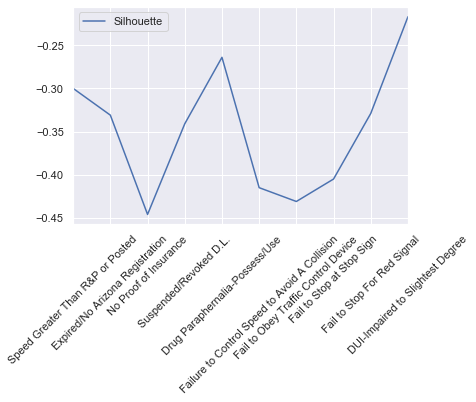

In [86]:
pd.DataFrame(data= {'Silhouette': sil_score},
            index=list(df.charge_description.unique())).plot()

# plt.ylabel('Score Index')
# plt.xlabel('Clusters')
plt.xticks(rotation=45);

### None of these silhouette indexes look great, silhouette scores ranges from -1 for bad clusters to +1 for dense clusters.  However, this measure doesn't perform well with non-flat geometry, which might be the case here.